In [6]:
import pandas as pd
import requests
import lxml.html
import numpy as np
import re
from kiwipiepy import Kiwi
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import time
import urllib
import matplotlib.pyplot as plt
import string
import re

from sklearn.decomposition import TruncatedSVD
from gensim.matutils import Sparse2Corpus
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim_models

In [7]:
sim_pay_cafe = pd.read_csv('naver_cafe_간편결제.csv')
sim_pay_blog = pd.read_csv('naver_blog_간편결제.csv')

* [sim_pay](#sim_pay)
    + [title](#title)
    + [context](#context)
    + [title_context](#title_context)  

# sim_pay

In [8]:
sim_pay = pd.concat([ sim_pay_blog, sim_pay_cafe ] ).reset_index(drop = True ) ; sim_pay.head()

url        type  \
0      https://blog.naver.com/38sebal/222749094820  naver blog   
1    https://blog.naver.com/lee5600ng/222690482308  naver blog   
2     https://blog.naver.com/armeise5/222655948661  naver blog   
3      https://blog.naver.com/uchinup/222697016014  naver blog   
4  https://blog.naver.com/alsemfsla88/222624308796  naver blog   

                               title                date  \
0       간편결제 엘페이가 첫 결제라면 최대12000P 적립  2022. 5. 27. 16:31   
1      간편결제 서비스 사기피해자 방송을 보면서 포스팅합니다    2022. 4. 4. 5:30   
2  PG 단말기 사업자를 위한 간편결제 코엠페이먼츠 필요한 이유  2022. 2. 23. 20:20   
3      하인크코리아 모바일간편결제 서비스 바로다로 주가 강세   2022. 4. 11. 9:00   
4                디지털 화폐, 간편 결제와는 다른!  2022. 1. 17. 21:27   

                                             context  
0  요즘은 간편결제를 많은 사람들이 사용한다.\n나도 온라인 결제는 대부분 간편결제 방...  
1  안녕하세요\n이영희 블로그 방문 감사합니다\n#간편결제 #서비스 #사기피해자\n간편...  
2  PG 단말기 사업자를 위한 간편결제 코엠페이먼츠 필요한 이유\n안녕하세요? 채이파파...  
3  하인크코리아는 스타벅스가 추진하고 있는 디지털 플라이휠(Digital Flywhee...  
4  최근에는 지갑에 현금을 들고 다니는 사람들보다 인터넷 결제 스마트폰에 등록된 카드 ...

In [9]:
# 중복값 처리 
sim_pay.drop_duplicates(inplace = True )

# 결측값 처리
sim_pay.fillna("no_context", inplace = True)
sim_pay = sim_pay[sim_pay["context"] != "no_context"].reset_index(drop = True)

# 특수문자 제거
sim_pay["context"] = sim_pay["context"].apply(lambda x: x.replace("\n", " ")).apply(lambda x:re.sub(r'[^\w\s]', '', x))

# 제목 + 내용
sim_pay['title_context'] = sim_pay['title'] + ' '  + sim_pay['context']

In [10]:
stop_word = pd.read_csv("korean_stopwords.txt")
stop_word = stop_word.T.reset_index(drop=False).T.reset_index(drop = True)
stop_word.columns = ["token"]

In [11]:
def extract_noun(text):
    result = kiwi.analyze(text)
    stop_words = list(stop_word["token"])
    for token , pos , _ , _ in result[0][0]:
        if pos[0] in "NVI":
            if token not in stop_words:
                    if len(token) > 1:
                        yield token

## title

In [12]:
kiwi = Kiwi()
kiwi.prepare()

cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(sim_pay["title"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

C:\Users\USER\anaconda3\lib\site-packages\kiwipiepy\_wrap.py:612: DeprecationWarning: `prepare()` has no effect and will be removed in future version.
  warnings.warn(


In [13]:
sim_pay_tf = word_count.sort_values("빈도",ascending = False)
sim_pay_tf = sim_pay_tf[sim_pay_tf.빈도 >= 10]
sim_pay_tf.head(10)

단어    빈도       빈도가중치
151      결제  5344  539.359591
3954     페이  1326  265.544581
1781    서비스   666  167.121665
3533     카드   655  152.992238
532     네이버   463  135.858548
4220     할인   416  124.441668
1187    모바일   391  115.293110
2838    이벤트   234   68.398948
3974    페이코   225   77.280773
3552  카카오페이   206   64.493084

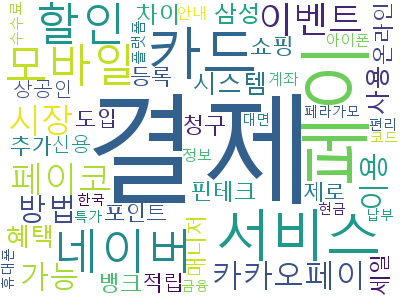

In [14]:
from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()

### LSA

In [15]:
svd = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100,
                  random_state=0)
svd.fit(tdm)
len(svd.components_)

print(np.shape(svd.components_))

terms = cv.get_feature_names()

def get_topics(components, feature_names, n=5) : 
    for idx, topic in enumerate(components) : # 각 토픽에 대한 주요 단어 n개 출력 
        print('Topic %d:' %(idx+1), [(feature_names[i], topic[i].round(5)) 
                    for i in topic.argsort()[:-n - 1 : -1]])
get_topics(svd.components_, terms)

(20, 4437)
Topic 1: [('결제', 0.92926), ('페이', 0.25669), ('카드', 0.12471), ('서비스', 0.11252), ('네이버', 0.08493)]
Topic 2: [('페이', 0.87152), ('네이버', 0.33081), ('삼성', 0.09648), ('할인', 0.09244), ('청구', 0.08569)]
Topic 3: [('카드', 0.80528), ('할인', 0.21791), ('네이버', 0.19299), ('신용', 0.12509), ('청구', 0.09827)]
Topic 4: [('서비스', 0.7517), ('카드', 0.50009), ('모바일', 0.13273), ('페이', 0.07883), ('신용', 0.05763)]
Topic 5: [('할인', 0.60723), ('서비스', 0.46894), ('네이버', 0.41084), ('청구', 0.24948), ('혜택', 0.09489)]
Topic 6: [('모바일', 0.78052), ('할인', 0.37892), ('특가', 0.09695), ('페이', 0.07775), ('이용', 0.07323)]
Topic 7: [('네이버', 0.59363), ('모바일', 0.54097), ('카카오페이', 0.14685), ('시장', 0.09003), ('포인트', 0.08127)]
Topic 8: [('페이코', 0.56606), ('이벤트', 0.44336), ('카카오페이', 0.22329), ('방법', 0.20052), ('포인트', 0.17942)]
Topic 9: [('카카오페이', 0.58603), ('브랜드', 0.30471), ('방법', 0.15958), ('평판', 0.15548), ('분석', 0.15158)]
Topic 10: [('이벤트', 0.56907), ('시장', 0.3746), ('카카오페이', 0.33075), ('뱅크', 0.23808), ('브랜드', 0.19557)]
Topic 11: 

### LDA

In [16]:
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)

def tokenizer(text):
    words = []
    stop_words = list(stop_word["token"])
    for word in token_re.findall(text):
        if word not in stop_words:
            words.append(word)
    return words

docs = []
for text in sim_pay["title"]:
    doc = tokenizer(text)
    docs.append(doc)
    
dic = Dictionary(docs)
dic.filter_extremes(no_below=10, no_above=0.9)

corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)
    
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.2, random_state=5432)

In [17]:
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=100,
    random_state=1234)

old_loss = -np.inf
loss = model.log_perplexity(valid_corpus)

while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-28.61676092109877
-28.441454107582484
-28.36769720091363


In [18]:
model.get_term_topics(dic.token2id['포인트'], 0.01)

[(78, 0.96176124), (81, 0.07474694)]

In [22]:
model.show_topic(78)

[('포인트', 0.961924),
 ('티셔츠', 0.0002907367),
 ('추가', 0.00028318173),
 ('몽클레어키즈', 0.00017312598),
 ('한점', 0.00010137187),
 ('반팔', 9.841567e-05),
 ('토스페이', 8.2693456e-05),
 ('11월', 8.2693456e-05),
 ('전쟁', 8.2693456e-05),
 ('실적', 8.2693456e-05)]

In [23]:
model.show_topic(81)

[('12월', 0.22604021),
 ('네이버', 0.088393465),
 ('포인트', 0.07720195),
 ('카드', 0.071597256),
 ('KB국민', 0.0659304),
 ('네이버페이', 0.06461281),
 ('혜택', 0.062104363),
 ('최대', 0.061640926),
 ('적립', 0.059797727),
 ('2020년', 0.05616733)]

## context

In [25]:
kiwi = Kiwi()
kiwi.prepare()

cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(sim_pay["context"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

C:\Users\USER\anaconda3\lib\site-packages\kiwipiepy\_wrap.py:612: DeprecationWarning: `prepare()` has no effect and will be removed in future version.
  warnings.warn(


In [26]:
sim_pay_tf = word_count.sort_values("빈도",ascending = False)
sim_pay_tf = sim_pay_tf[sim_pay_tf.빈도 >= 10]
sim_pay_tf.head(10)

단어     빈도       빈도가중치
209    결제  64702  821.260434
4173   카드  22054  428.090362
4524   페이  17826  306.247421
2077  서비스  15242  250.454759
1928   사용  11253  185.274504
12     가능   9814  165.883637
3253   이용   9561  162.845715
4755   할인   7085  173.718308
2467   신용   6149  210.901238
737   네이버   5925  157.703149

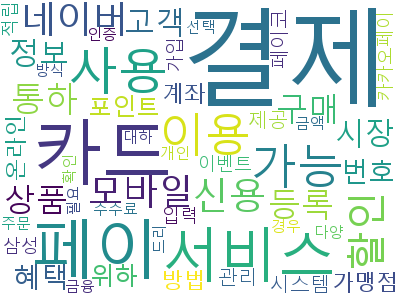

In [27]:
from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()

### LSA

In [28]:
svd = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100,
                  random_state=0)
svd.fit(tdm)
len(svd.components_)

print(np.shape(svd.components_))

terms = cv.get_feature_names()

def get_topics(components, feature_names, n=5) : 
    for idx, topic in enumerate(components) : # 각 토픽에 대한 주요 단어 n개 출력 
        print('Topic %d:' %(idx+1), [(feature_names[i], topic[i].round(5)) 
                    for i in topic.argsort()[:-n - 1 : -1]])
get_topics(svd.components_, terms)

(20, 5000)
Topic 1: [('결제', 0.80734), ('카드', 0.2666), ('페이', 0.21747), ('서비스', 0.18596), ('사용', 0.13959)]
Topic 2: [('카드', 0.53426), ('할인', 0.42667), ('청구', 0.20595), ('혜택', 0.13864), ('적립', 0.13609)]
Topic 3: [('페이', 0.68483), ('네이버', 0.29131), ('서비스', 0.20479), ('삼성', 0.16892), ('브랜드', 0.1605)]
Topic 4: [('할인', 0.38919), ('페이코', 0.25006), ('결제', 0.21887), ('포인트', 0.15623), ('적립', 0.13894)]
Topic 5: [('사용', 0.43289), ('페이', 0.26928), ('가능', 0.22206), ('등록', 0.20674), ('페이코', 0.16992)]
Topic 6: [('결제', 0.34163), ('페이', 0.27545), ('브랜드', 0.19293), ('지수', 0.18126), ('평판', 0.13205)]
Topic 7: [('브랜드', 0.53833), ('지수', 0.49243), ('평판', 0.34494), ('분석', 0.18336), ('빅데이터', 0.12857)]
Topic 8: [('페이코', 0.36435), ('적립', 0.22304), ('포인트', 0.19862), ('시장', 0.19506), ('수수료', 0.15355)]
Topic 9: [('서비스', 0.38926), ('페이코', 0.24252), ('카드', 0.20705), ('적립', 0.13111), ('삼성', 0.10824)]
Topic 10: [('메투', 0.26673), ('네이버', 0.24115), ('상품', 0.23583), ('관리', 0.23166), ('고객', 0.20338)]
Topic 11: [('네이버', 0.33

### LDA

In [29]:
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)

def tokenizer(text):
    words = []
    stop_words = list(stop_word["token"])
    for word in token_re.findall(text):
        if word not in stop_words:
            words.append(word)
    return words

docs = []
for text in sim_pay["context"]:
    doc = tokenizer(text)
    docs.append(doc)
    
dic = Dictionary(docs)
dic.filter_extremes(no_below=10, no_above=0.9)

corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)
    
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.2, random_state=5432)

In [30]:
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=100,
    random_state=1234)

old_loss = -np.inf
loss = model.log_perplexity(valid_corpus)

while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-11.449663094477051
-10.820535610105205
-10.604912468861142
-10.505898155180772


In [31]:
model.get_term_topics(dic.token2id['포인트'], 0.01)

[(41, 0.0105778), (53, 0.034701616), (71, 0.010653215), (85, 0.012356409)]

In [33]:
model.show_topic(53)

[('포인트', 0.034709953),
 ('포인트를', 0.0172901),
 ('결제', 0.012867528),
 ('PAYCO', 0.011122731),
 ('간편결제', 0.011044426),
 ('있는', 0.009659959),
 ('페이코', 0.008153611),
 ('계좌', 0.0077061295),
 ('사용할', 0.0068675885),
 ('계좌를', 0.006094546)]

In [34]:
model.show_topic(10)

[('바코드', 0.04211569),
 ('pay', 0.036852177),
 ('T페이', 0.030396417),
 ('페이북', 0.028777596),
 ('멤버십', 0.026265591),
 ('결제를', 0.025052749),
 ('결제', 0.024710815),
 ('이벤트', 0.019989276),
 ('CU', 0.018702708),
 ('100', 0.015726553)]

In [35]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dic, sort_topics=False)
pyLDAvis.display(p) 

C:\Users\USER\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


## title_context

In [36]:
kiwi = Kiwi()
kiwi.prepare()

cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(sim_pay["title_context"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

C:\Users\USER\anaconda3\lib\site-packages\kiwipiepy\_wrap.py:612: DeprecationWarning: `prepare()` has no effect and will be removed in future version.
  warnings.warn(


In [37]:
sim_pay_tf = word_count.sort_values("빈도",ascending = False)
sim_pay_tf = sim_pay_tf[sim_pay_tf.빈도 >= 10]
sim_pay_tf.head(10)

단어     빈도       빈도가중치
204    결제  70047  851.954839
4175   카드  22720  416.076606
4534   페이  19162  315.434381
2085  서비스  15911  252.624988
1937   사용  11416  180.429103
11     가능  10008  160.248056
3259   이용   9748  159.555863
4763   할인   7489  177.260074
734   네이버   6399  165.050552
2476   신용   6242  200.403110

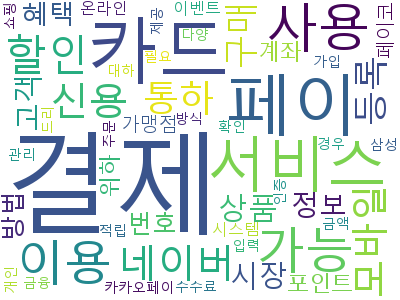

In [38]:
from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()

### LSA

In [39]:
svd = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100,
                  random_state=0)
svd.fit(tdm)
len(svd.components_)

print(np.shape(svd.components_))

terms = cv.get_feature_names()

def get_topics(components, feature_names, n=5) : 
    for idx, topic in enumerate(components) : # 각 토픽에 대한 주요 단어 n개 출력 
        print('Topic %d:' %(idx+1), [(feature_names[i], topic[i].round(5)) 
                    for i in topic.argsort()[:-n - 1 : -1]])
get_topics(svd.components_, terms)

(20, 5000)
Topic 1: [('결제', 0.81464), ('카드', 0.26073), ('페이', 0.22048), ('서비스', 0.18417), ('사용', 0.13493)]
Topic 2: [('카드', 0.54026), ('할인', 0.42809), ('청구', 0.20956), ('혜택', 0.13847), ('적립', 0.13402)]
Topic 3: [('페이', 0.71005), ('네이버', 0.29991), ('서비스', 0.19026), ('삼성', 0.16625), ('브랜드', 0.15973)]
Topic 4: [('할인', 0.42529), ('페이코', 0.24657), ('결제', 0.2078), ('포인트', 0.14912), ('쿠폰', 0.13207)]
Topic 5: [('사용', 0.41086), ('페이', 0.2705), ('가능', 0.21139), ('등록', 0.1941), ('페이코', 0.18538)]
Topic 6: [('결제', 0.35331), ('페이', 0.2228), ('브랜드', 0.18936), ('지수', 0.16829), ('평판', 0.12773)]
Topic 7: [('브랜드', 0.55072), ('지수', 0.4781), ('평판', 0.34998), ('분석', 0.19164), ('페이코', 0.14457)]
Topic 8: [('페이코', 0.35942), ('적립', 0.21643), ('시장', 0.20242), ('포인트', 0.19554), ('수수료', 0.16496)]
Topic 9: [('서비스', 0.39863), ('페이코', 0.26498), ('카드', 0.17642), ('적립', 0.1408), ('삼성', 0.10523)]
Topic 10: [('모바일', 0.30017), ('사용', 0.24268), ('할인', 0.22071), ('삼성', 0.12457), ('시장', 0.12353)]
Topic 11: [('수수료', 0.2531), 

### LDA

In [40]:
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)

def tokenizer(text):
    words = []
    stop_words = list(stop_word["token"])
    for word in token_re.findall(text):
        if word not in stop_words:
            words.append(word)
    return words

docs = []
for text in sim_pay["title_context"]:
    doc = tokenizer(text)
    docs.append(doc)
    
dic = Dictionary(docs)
dic.filter_extremes(no_below=10, no_above=0.9)

corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)
    
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.2, random_state=5432)

In [41]:
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=100,
    random_state=1234)

old_loss = -np.inf
loss = model.log_perplexity(valid_corpus)

while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-11.39886999160084
-10.773828344387626
-10.555529485513294
-10.456566851525652


In [42]:
model.get_term_topics(dic.token2id['포인트'], 0.01)

[(3, 0.011967297),
 (21, 0.01686891),
 (30, 0.016425809),
 (44, 0.011827343),
 (49, 0.013405108),
 (71, 0.012706888),
 (74, 0.020139309),
 (78, 0.049276367)]

In [43]:
model.show_topic(78)

[('페이코', 0.2595151),
 ('포인트', 0.049292948),
 ('간편결제', 0.030880976),
 ('페이코는', 0.028332854),
 ('페이코를', 0.02511517),
 ('페이코로', 0.024119485),
 ('티머니', 0.021406164),
 ('페이코의', 0.018044252),
 ('할인', 0.017325284),
 ('아시는', 0.014374019)]

In [44]:
model.show_topic(10)

[('상품은', 0.03326513),
 ('안내', 0.033231083),
 ('모든', 0.032827258),
 ('안될시', 0.032780502),
 ('않습니다', 0.017354596),
 ('주문', 0.017007265),
 ('고객센터', 0.016896784),
 ('바로가기', 0.016654043),
 ('있으며', 0.016610034),
 ('고객센터를', 0.016506555)]

In [45]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dic, sort_topics=False)
pyLDAvis.display(p) 

C:\Users\USER\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
